In [2]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
from datetime import datetime

In [3]:
data = pd.read_csv("meta.csv")
print(data.head())
print(data.info())
print(data.describe())

         Date Close/Last    Volume      Open       High      Low
0  08/15/2025    $785.23  13375360   $784.15    $796.25  $780.82
1  08/14/2025    $782.13   8116193   $777.88    $787.81  $772.51
2  08/13/2025    $780.08   8811750   $791.15  $795.4561  $778.23
3  08/12/2025    $790.00  14579770   $773.00    $793.67  $772.43
4  08/11/2025    $765.87   7611964  $770.075  $773.4584  $764.67
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
 2   Volume      2515 non-null   int64 
 3   Open        2515 non-null   object
 4   High        2515 non-null   object
 5   Low         2515 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.0+ KB
None
             Volume
count  2.515000e+03
mean   2.213490e+07
std    1.473506e+07
min    4.726056e+06
25%    1.365560e+07
50%    

In [4]:
#Initial Data Processing
data['Open'] = data['Open'].str[1:].astype(float)
data['Close/Last'] = data['Close/Last'].str[1:].astype(float)


In [5]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

Initial Data Visualization

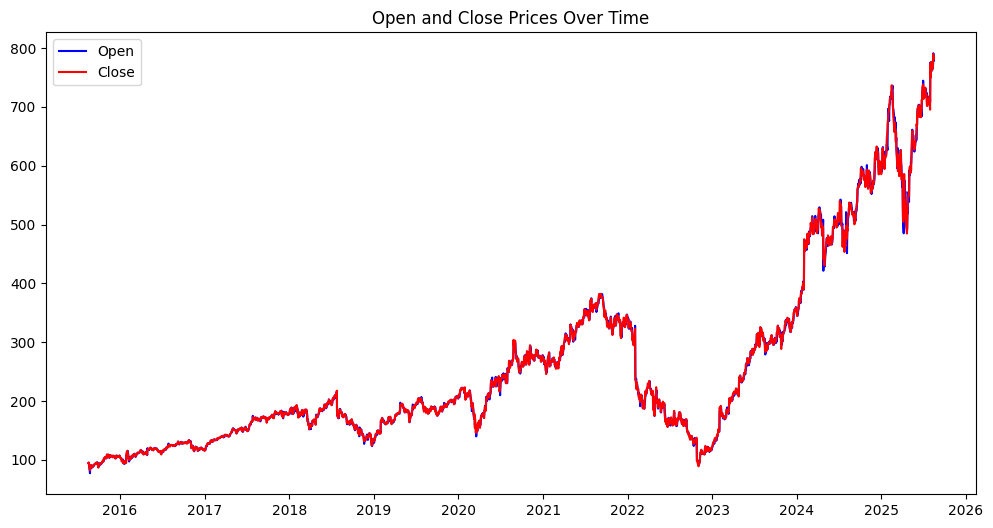

In [6]:
#Plot 1 Open and Close prices
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Open'], label="Open", color="blue") 
plt.plot(data['Date'], data['Close/Last'], label="Close", color="red") 
plt.title("Open and Close Prices Over Time")
plt.legend()
plt.show()

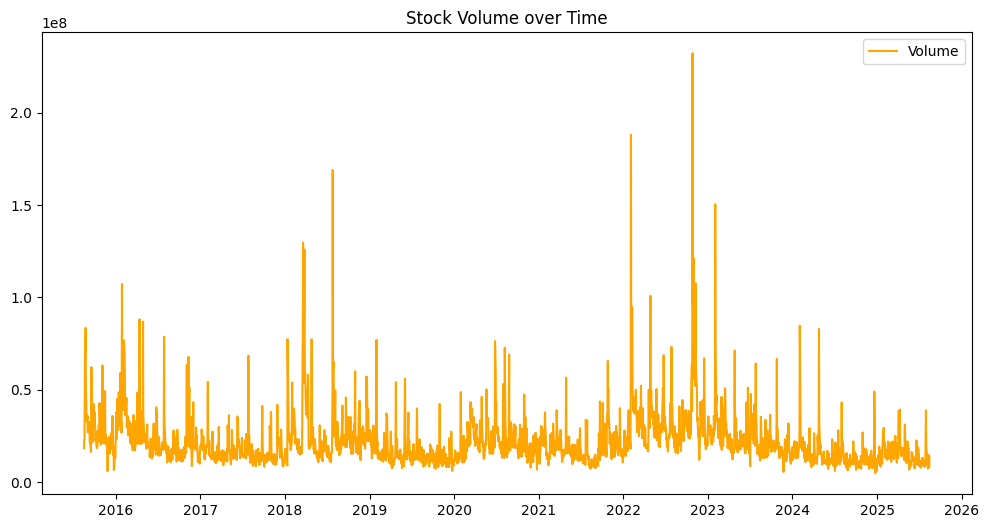

In [7]:
#Plot 2 Trading Volume (Checking for Outliers)
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Volume'], label="Volume", color="orange")
plt.title("Stock Volume over Time")
plt.legend()
plt.show()

In [8]:
#Drop Non-numeric Columns

numeric_data = data[['Open', 'Close/Last', 'Volume']]

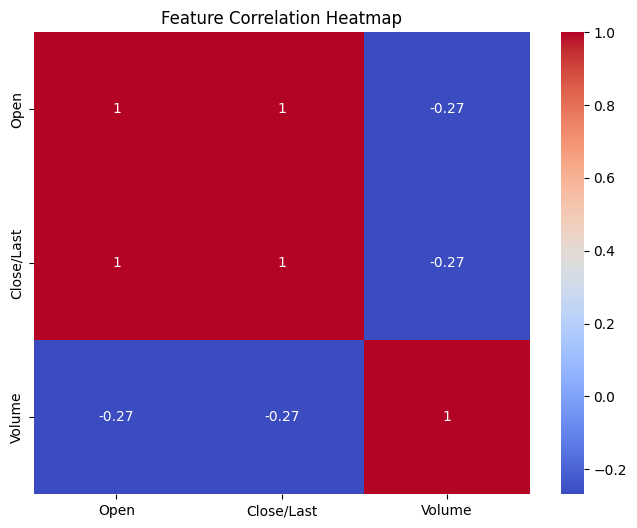

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
# Prepare for the LSTM Model (Sequential)
stock_close = data.filter(["Close/Last"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))


In [11]:
# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len] #95% of all out data

X_train, y_train = [], []


In [12]:

# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
#Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()

#1st Layer
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

#2nd Layer
model.add(LSTM(64, return_sequences=False))

#3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))

#4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))

#Final output layer
model.add(keras.layers.Dense(1))

/Users/smritirangarajan/Desktop/lstm-time-series/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Prep the test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]


for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

In [16]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [17]:
# Plotting data
train = data[:training_data_len]
test =  data[training_data_len:]

test = test.copy()

test.iloc[60:, 'Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['Date'], train['Close/Last'], label="Train (Actual)", color='blue')
plt.plot(test['Date'], test['Close/Last'], label="Test (Actual)", color='orange')
plt.plot(test['Date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

ValueError: Must have equal len keys and value when setting with an ndarray